METIS PROJECT 4: Game of Thrones

In [295]:
import pandas as pd
import numpy as np
import re
import codecs
import json
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import sent_tokenize
from textblob import TextBlob
from copy import deepcopy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import multiprocessing
import gensim
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#from nltk.tokenize import WhitespaceTokenizer
#from scipy.interpolate import spline
#import scipy
from itertools import chain
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

%matplotlib inline

pd.options.display.float_format = '{:20,.3f}'.format
pd.options.display.max_columns = 15
pd.options.display.max_rows = 500

In [296]:
characters = [
]

my_stops = stopwords.words('english') + characters

In [297]:
def make_df(filename):
    # make list of chapters
    book = make_file(filename)
    
    # turn book into dataframe
    book_df = pd.DataFrame(book)
    book_df.columns = ['chapter_text']
    
    # add column with chapter's POV character
    book_df['chapter_name'] = book_df['chapter_text'].apply(chap_char)
    
    # remove chapter title from chapter_text
    book_df['chapter_text'] = book_df.apply(lambda row: row['chapter_text'][len(row['chapter_name']):], axis=1)
    
    # add column with book title
    title = book_df.ix[0, 1]
    book_df['book_title'] = title
    
    # drop first row with book basic info
    book_df.drop(0, inplace=True)
    
    # add column with chapter number
    book_df['chapter_num'] = book_df.index
    book_df = book_df[['book_title', 'chapter_num', 'chapter_name', 'chapter_text']]
    
    return book_df

    
def make_file(filename):
    # read in book text by line
    with codecs.open(filename, mode='r') as f:
        txt = f.read().splitlines()
    
    # concatinate lines in the same chapter
    book = []
    # initialize to false for first chapter
    end = False 
    
    for i in range(0, len(txt)):
        # remove page numbers and chapter headers
        txt[i] = re.sub('Page [0-9]*', '', txt[i])
        txt[i] = re.sub('Chapter [0-9]*', '', txt[i])
        
        # skip blank lines
        if not txt[i] or re.match("^ *$", txt[i]):
            continue
        
        # find chapter begining which start with character name capitalized
        elif re.match("^[ A-Z]*$", txt[i]):
            if end:
                # append previous chapter to list (false for first chapter)
                book.append(chapter) 
            # start new chapter
            chapter = txt[i]
            # set end to true for subsequent chapters after first chapter
            end = True
        
        # if not begining of chapter, add lines to chapter
        else:
            chapter = chapter + txt[i]
    book.append(chapter)
    return book


def chap_char(x):
    # Find character name in all caps
    name = re.findall(r'^[ A-Z]*', x)
    
    # clean name
    name = name[0]
    name = name[:-1]
    name = name.strip()
    if name[-2:] == ' A':
        name = name[:-2]
        name = name.strip() 
    return name


def sent_breakout(x, n, skip=True):
    scores =[]
    for i in x:
        score = TextBlob(i).sentiment[n]
        if skip:
            if score:
                scores.append(score)
        else:
            scores.append(score)
    return scores


def sentiment_smooth(data, smooth=10):
    y = np.array(data)
    x = np.array(range(0, len(y)))

    x_smooth = np.linspace(x.min(), x.max(), smooth)
    
    groups = np.array_split(y, smooth)
    
    y_smooth = []
    for group in groups:
        y_smooth.append(group.mean())
    
    figure, ax = plt.subplots(figsize=(15, 5))
    plt.plot(x_smooth, y_smooth);
    d = np.zeros(len(y_smooth))
    ax.fill_between(x_smooth, y_smooth, where=y_smooth >= d, interpolate=True, color='yellow')
    ax.fill_between(x_smooth, y_smooth, where=y_smooth <= d, interpolate=True, color='red')
    plt.xlim(0, x.max())
    
    
def sentiment_runavg(data, runavg=10, color_pos='yellow', color_neg='red'):
    y = np.array(data)    
    
    y_runavg = np.convolve(y, np.ones((runavg,))/runavg, mode='valid')
    x = np.array(range(0, len(y_runavg)))
    
    figure, ax = plt.subplots(figsize=(25, 7))
    plt.plot(x, y_runavg);
    d = np.zeros(len(y_runavg))
    ax.fill_between(x, y_runavg, where=y_runavg >= d, interpolate=True, color=color_pos)
    ax.fill_between(x, y_runavg, where=y_runavg <= d, interpolate=True, color=color_neg)
    plt.xlim(0, x.max())
    
    
def remove_stops(document):
    stoplist = stopwords.words('english')
    new_doc = []
    for i, sentence in enumerate(document):
        new_sentence = re.sub(r'[^a-zA-Z ]','', sentence)
        new_sentence = new_sentence.lower()
        new_sentence = new_sentence.split()
        new_sentence = [word for word in new_sentence if word not in stoplist]
        new_sentence = ' '.join(new_sentence)
        new_doc.append(new_sentence)
    return new_doc


def pos_remove(document):
    new_doc = []
    for i, sentence in enumerate(document):
        words = pos_tag(word_tokenize(sentence))
        pos = ['NN', 'NNS', 'NNP', 'NNPS']
        new_sentence = []
        for word in words:
            if word[1] in pos:
                new_sentence.append(word[0])
        new_sentence = ' '.join(new_sentence)
        new_doc.append(new_sentence)
    return new_doc


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print "Topic #%d:" % topic_idx
        print " ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]])
        
        
def char_sent_plot(name, n, color_pos='grey', color_neg='black'):
    char_chap = ice_and_fire.stop_polarity[ice_and_fire.pov == name]
    char = []
    for chapter in char_chap:
        char += chapter

    sentiment_runavg(char, runavg=n, color_pos=color_pos, color_neg=color_neg)


def quotes(text):
    quotes = []
    for sentence in text:
        if '"' in sentence:
            quotes.append(sentence)
    return quotes


def prep_docs(chapters):
    docs = []
    for chapter in chapters:
        count = 0
        s = ''
        for sentence in chapter:
            count += 1
            s = s + sentence + ' '
            if count == 15:
                docs.append(s)
                count = 0
                s =''
        if s:
            docs.append(s)
    docs = pd.DataFrame(docs, columns=['sentences'])
    return docs
 

def topic_model(docs, ntops=3, n_top_words=20, maxdf=.99, mindf=.05):
    count_vectorizer = CountVectorizer(stop_words=my_stops, max_df=maxdf, min_df=mindf)
    cv = count_vectorizer.fit_transform(docs)
    nmf = NMF(n_components=ntops, random_state=1).fit(cv)
    feature_names = count_vectorizer.get_feature_names()
    print_top_words(nmf, feature_names, n_top_words)

In [298]:
# Make dataframe for each book
file1 = "GOTbooks/001ssb.txt"
file2 = "GOTbooks/002ssb.txt"
file3 = "GOTbooks/003ssb.txt"
file4 = "GOTbooks/004ssb.txt"
file5 = "GOTbooks/005ssb.txt"

game_of_thrones = make_df(file1)
clash_of_kings = make_df(file2)
storm_of_swords = make_df(file3)
feast_for_crows = make_df(file4)
dance_with_dragons = make_df(file5)

# Join books into one dataframe
book_names = [game_of_thrones, clash_of_kings, storm_of_swords, feast_for_crows, dance_with_dragons]
ice_and_fire = pd.concat(book_names)
ice_and_fire.reset_index(inplace=True, drop=True)

# Read in scraped Wiki data
with open('GOTscrapy/got_wiki.json') as filename:
    json_data = json.load(filename)

wiki = pd.DataFrame(json_data)

# Join book data and scraped data
ice_and_fire = ice_and_fire.join(wiki)

# Drop duplicate data and rearrange columns
ice_and_fire.drop(['book'], axis=1, inplace=True)
df_names = ['book_title', 'chapter_num', 'chapter_name', 'pov', 'chronology', 'setting', 'chapter_text']
ice_and_fire = ice_and_fire[df_names]
ice_and_fire.head()

,book_title,chapter_num,chapter_name,pov,chronology,setting,chapter_text
0,A GAME OF THRONES,1,PROLOGUE,Will,Prologue,Haunted forest,"""We should start back,"" Gared urged as the wo..."
1,A GAME OF THRONES,2,BRAN,Bran Stark,Bran I,Winterfell,"The morning had dawned clear and cold, with a..."
2,A GAME OF THRONES,3,CATELYN,Catelyn Stark,Catelyn I,Winterfell,Catelyn had never liked this godswood. She ha...
3,A GAME OF THRONES,4,DAENERYS,Daenerys Targaryen,Daenerys I,Pentos,Her brother held the gown up for her inspecti...
4,A GAME OF THRONES,5,EDDARD,Eddard Stark,Eddard I,Winterfell,The visitors poured through the castle gates ...


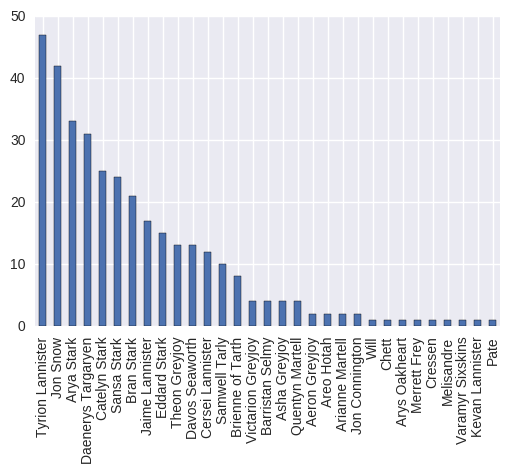

In [299]:
# POV character chapters
ice_and_fire.pov.value_counts().plot(kind='bar');

In [300]:
# Break up chapters into sentences
ice_and_fire['sentences'] = ice_and_fire.chapter_text.apply(sent_tokenize)

# Sentiment Analysis of sentences in each chapter
#ice_and_fire['sentence_polarity'] = ice_and_fire['sentences'].apply(lambda x: sent_breakout(x, 0))

# Remove stop words from sentences
ice_and_fire['sentences_stop'] = ice_and_fire['sentences'].apply(remove_stops)

# Sentiment Analysis of stop sentences in each chapter
ice_and_fire['stop_polarity'] = ice_and_fire['sentences_stop'].apply(lambda x: sent_breakout(x, 0))

ice_and_fire['convo'] = ice_and_fire['sentences'].apply(quotes)
#ice_and_fire['convo_polarity'] = ice_and_fire['convo'].apply(lambda x: sent_breakout(x, 0))

# sentences just adjectives and verbs
ice_and_fire['pos_sentences'] = ice_and_fire['sentences'].apply(pos_remove)

ice_and_fire.head()

,book_title,chapter_num,chapter_name,pov,chronology,setting,chapter_text,sentences,sentences_stop,stop_polarity,convo,pos_sentences
0,A GAME OF THRONES,1,PROLOGUE,Will,Prologue,Haunted forest,"""We should start back,"" Gared urged as the wo...","[ ""We should start back,"" Gared urged as the w...",[start back gared urged woods began grow dark ...,"[-0.075, -0.2, -0.2, 0.3, -0.075, -0.2, -0.2, ...","[ ""We should start back,"" Gared urged as the w...","[woods dark, wildlings, frighten, Ser Waymar R..."
1,A GAME OF THRONES,2,BRAN,Bran Stark,Bran I,Winterfell,"The morning had dawned clear and cold, with a...","[ The morning had dawned clear and cold, with ...",[morning dawned clear cold crispness hinted en...,"[-0.25, 0.116666666667, -0.125, 0.1, -1.0, -0....","[""Ice,"" that sword was called., He took hold o...","[morning crispness end summer, forth daybreak ..."
2,A GAME OF THRONES,3,CATELYN,Catelyn Stark,Catelyn I,Winterfell,Catelyn had never liked this godswood. She ha...,"[ Catelyn had never liked this godswood., She ...","[catelyn never liked godswood, born tully rive...","[-0.3, 0.05, 0.266666666667, 0.1375, 0.25, -0....","[""The heart tree,"" Ned called it., ""Ned,"" she ...","[Catelyn godswood, Riverrun south Red Fork Tri..."
3,A GAME OF THRONES,4,DAENERYS,Daenerys Targaryen,Daenerys I,Pentos,Her brother held the gown up for her inspecti...,[ Her brother held the gown up for her inspect...,"[brother held gown inspection, beauty, touch, ...","[0.4, 0.1, 0.2, 0.16, -0.1, 0.2, -0.1666666666...","[""This is beauty., Caress the fabric."", ""Is it...","[brother gown inspection, beauty, Touch, , Car..."
4,A GAME OF THRONES,5,EDDARD,Eddard Stark,Eddard I,Winterfell,The visitors poured through the castle gates ...,[ The visitors poured through the castle gates...,[visitors poured castle gates river gold silve...,"[0.433333333333, 0.15, 0.5, -0.15, -0.02916666...","[""Ned!, Ah, but it is good to see that frozen ...",[visitors castle river gold silver steel pride...


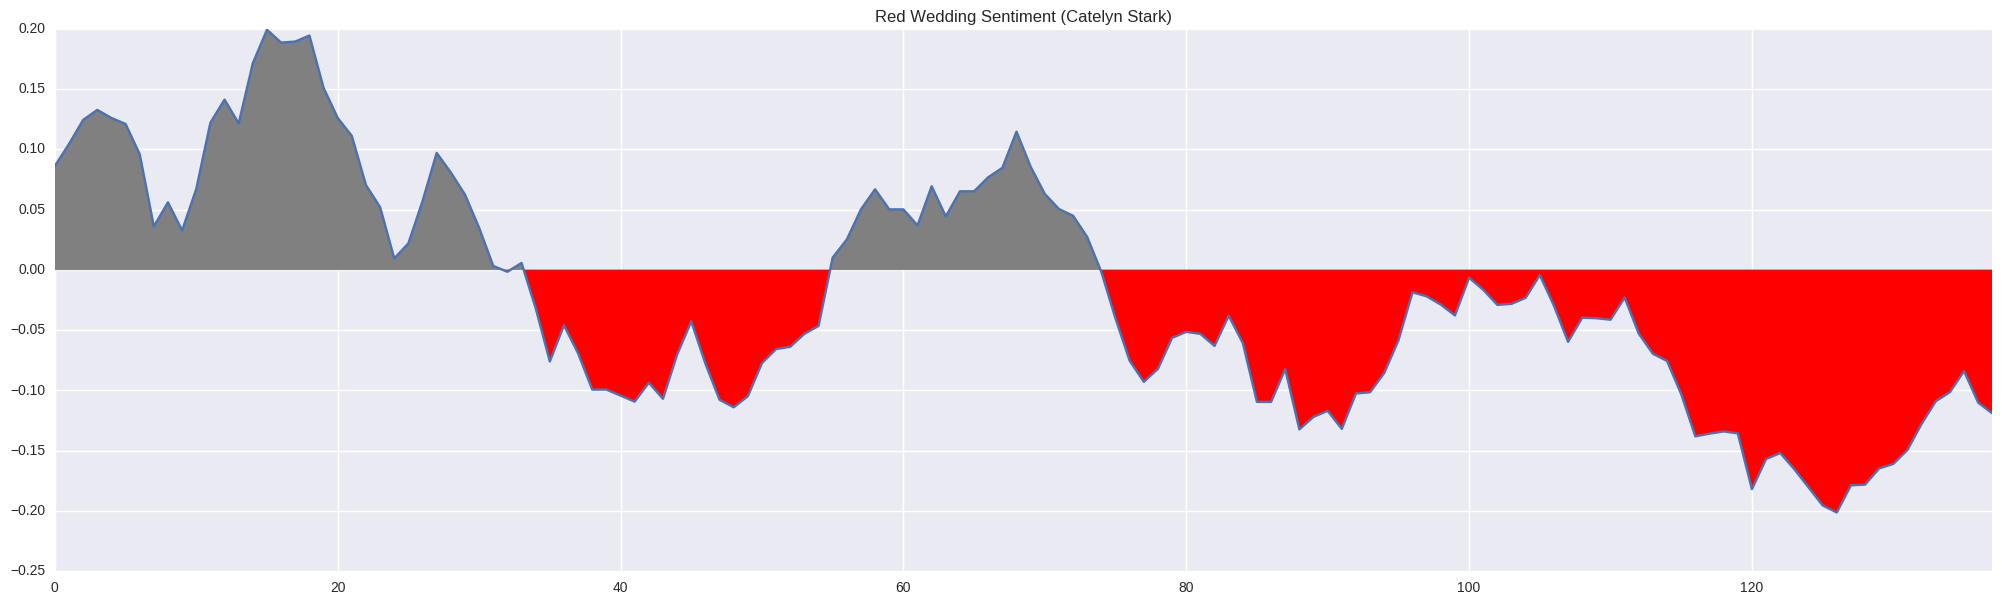

In [206]:
# Red Wedding sentiment from Catelyn's POV
sentiment_runavg(ice_and_fire.ix[194, 9], runavg=20, color_pos='grey', color_neg='red')
plt.title('Red Wedding Sentiment (Catelyn Stark)');

In [208]:
# Highest Point
rw_s = sent_breakout(ice_and_fire.ix[194, 7], 0, False)
index = rw_s.index(max(rw_s))
ice_and_fire.ix[194,7][index]

In [ ]:
index = rw_s.index(min(rw_s[:150]))
ice_and_fire.ix[194,7][index]  

In [227]:
index = rw_s.index(min(rw_s[150:]))
ice_and_fire.ix[194,7][index] 

"Her hand shook so badly she was ringing Jinglebell's head."

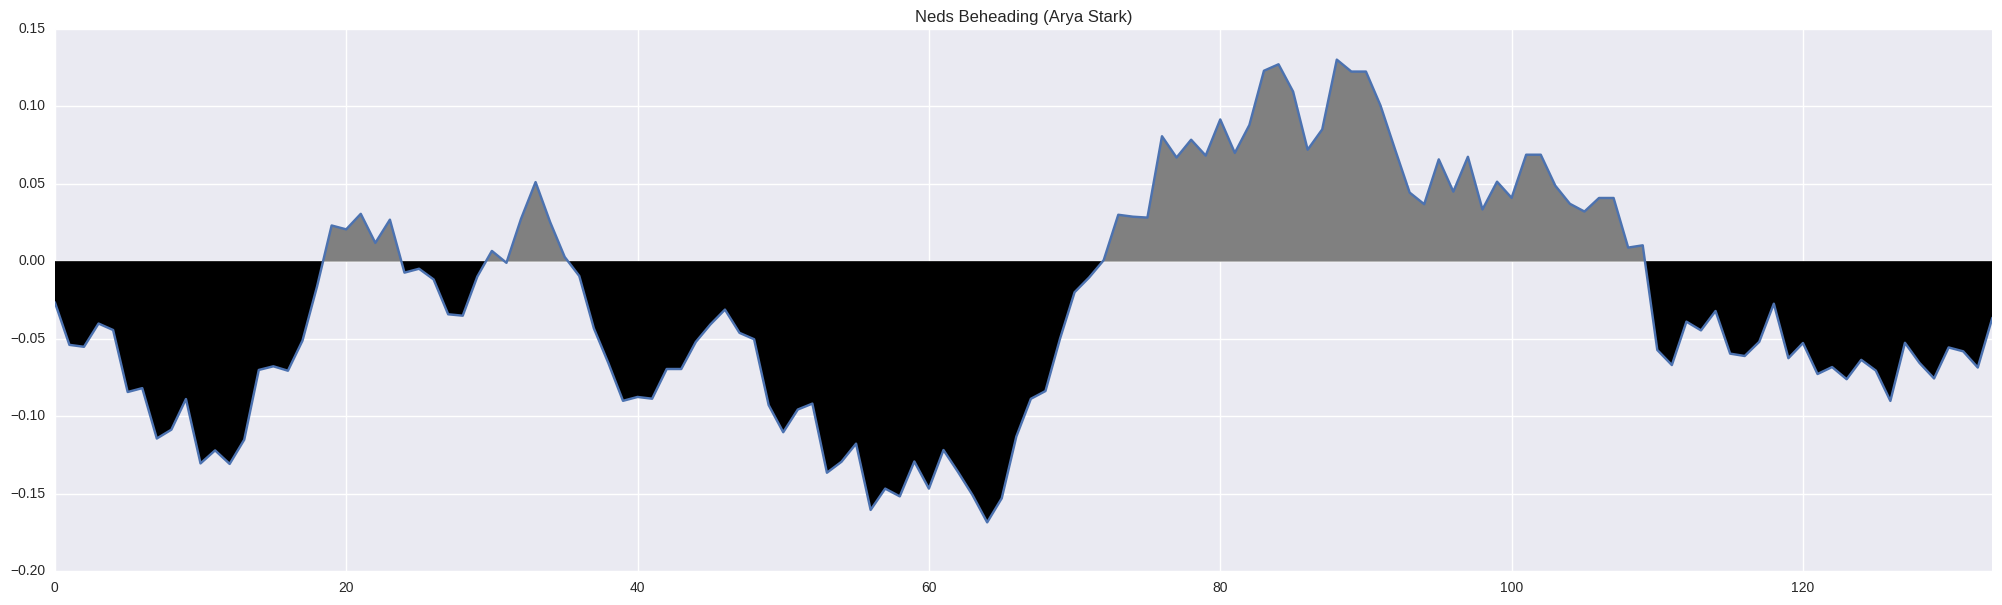

In [198]:
# Ned's Beheading sentiment from Arya's POV
sentiment_runavg(ice_and_fire.ix[65, 9], runavg=20, color_pos='grey', color_neg='black')
plt.title('Neds Beheading (Arya Stark)'); 

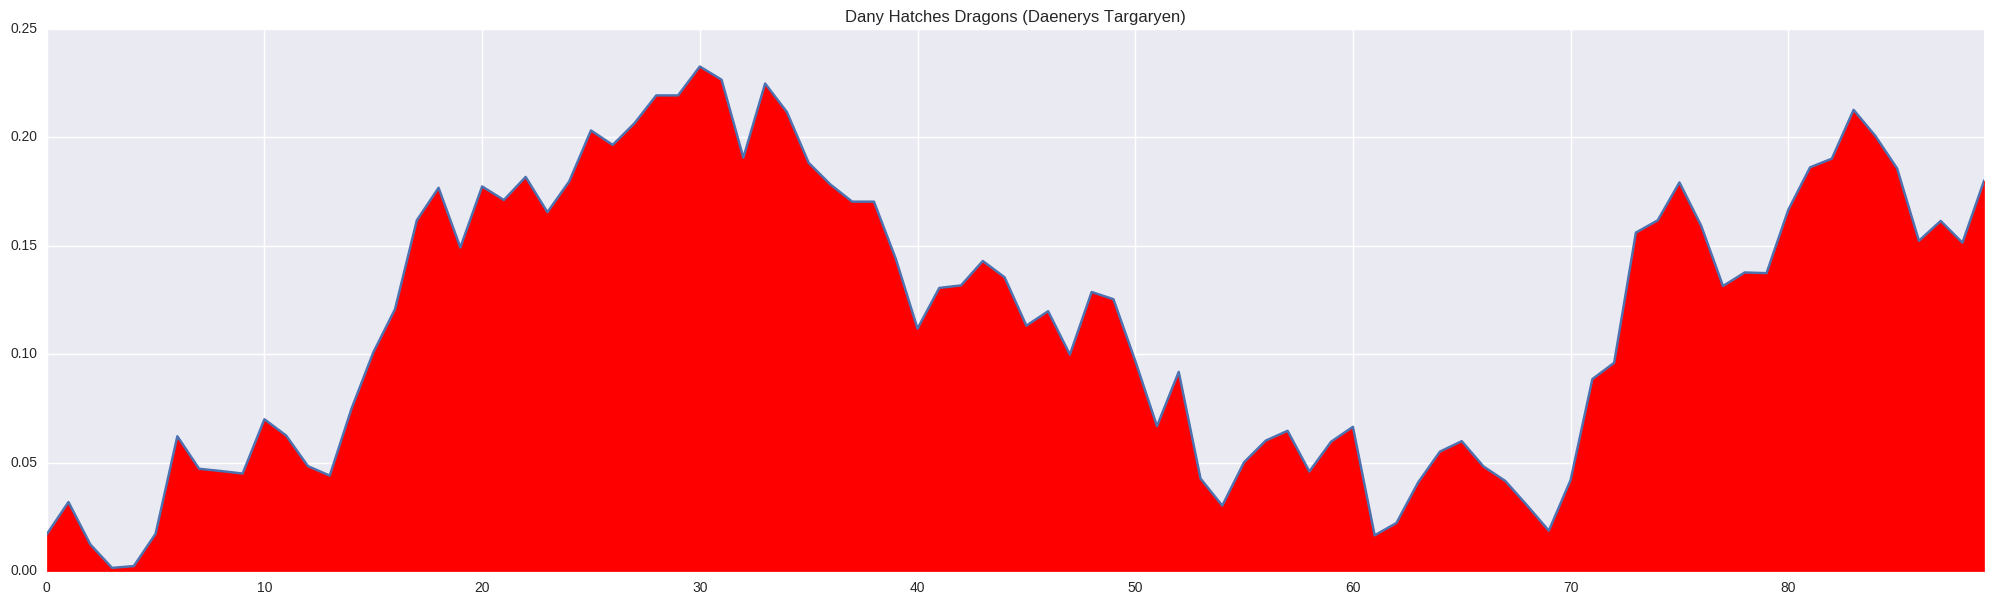

In [199]:
# Dany hatches dragons
sentiment_runavg(ice_and_fire.ix[72, 9], runavg=20, color_pos='red', color_neg='black')
plt.title('Dany Hatches Dragons (Daenerys Targaryen)');

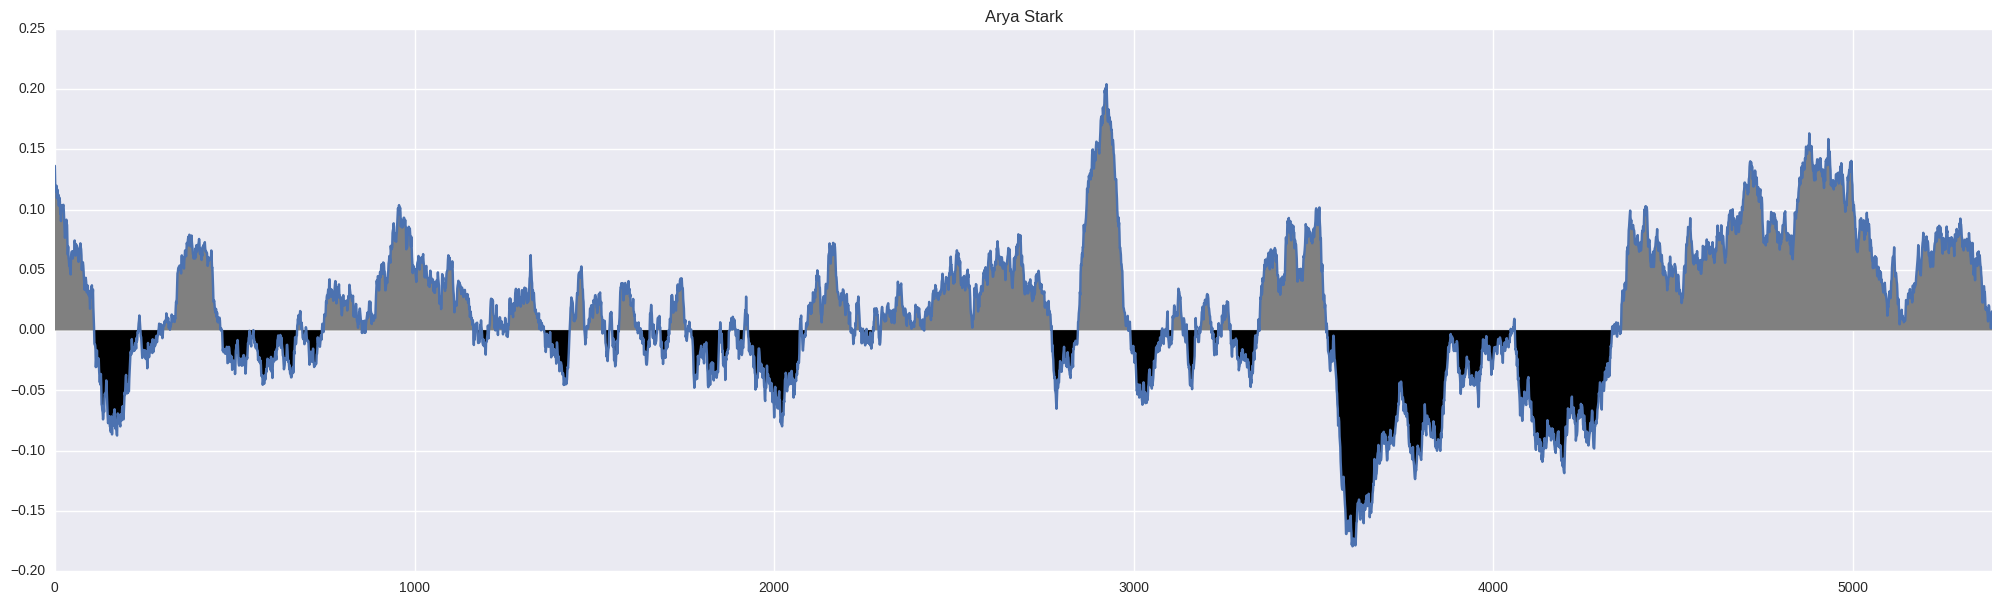

In [228]:
char_sent_plot("Arya Stark", n=100, color_pos='grey', color_neg='black')
plt.title('Arya Stark');

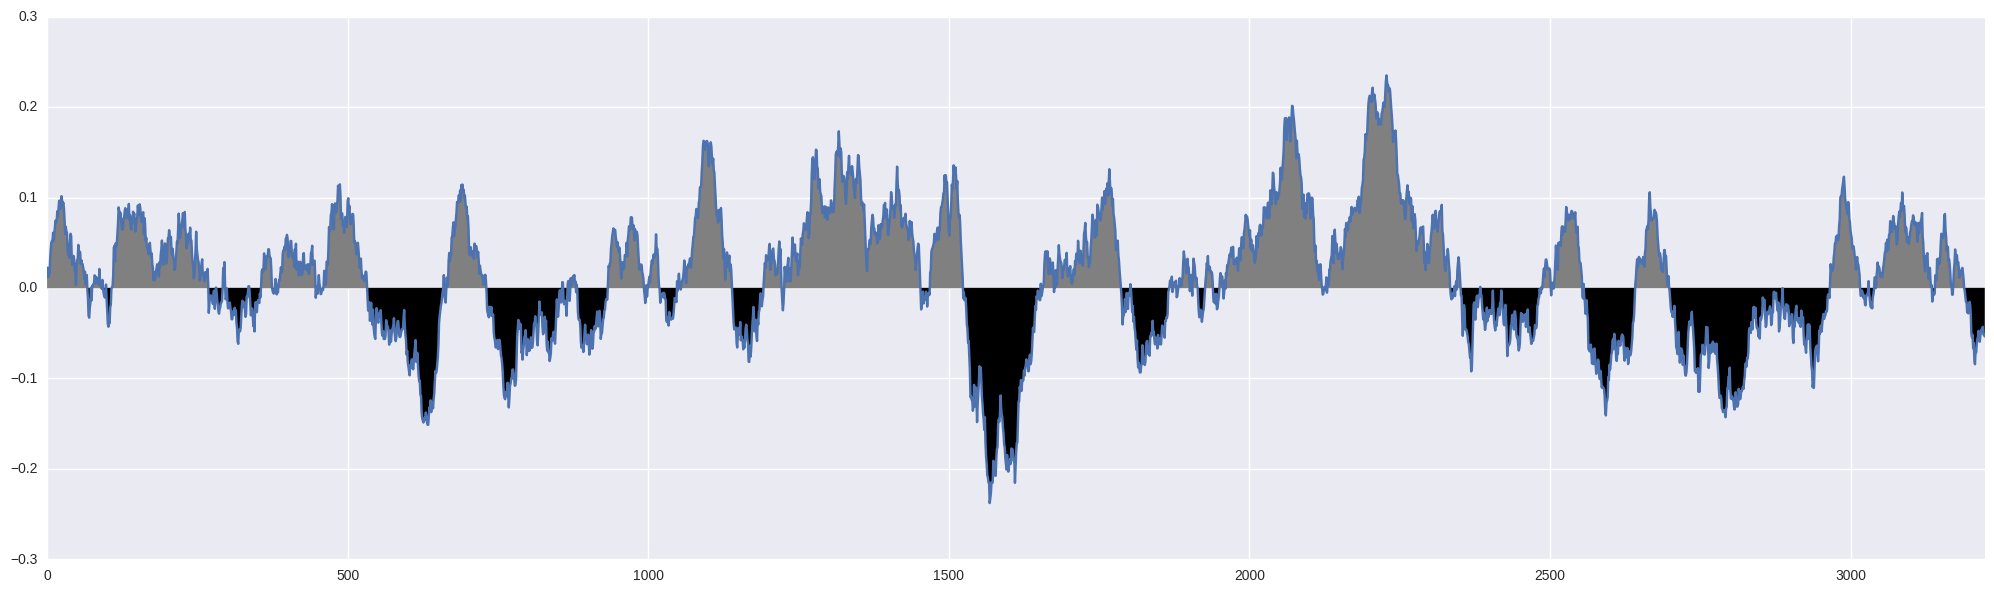

In [203]:
char_sent_plot("Bran Stark", n=50, color_pos='grey', color_neg='black')

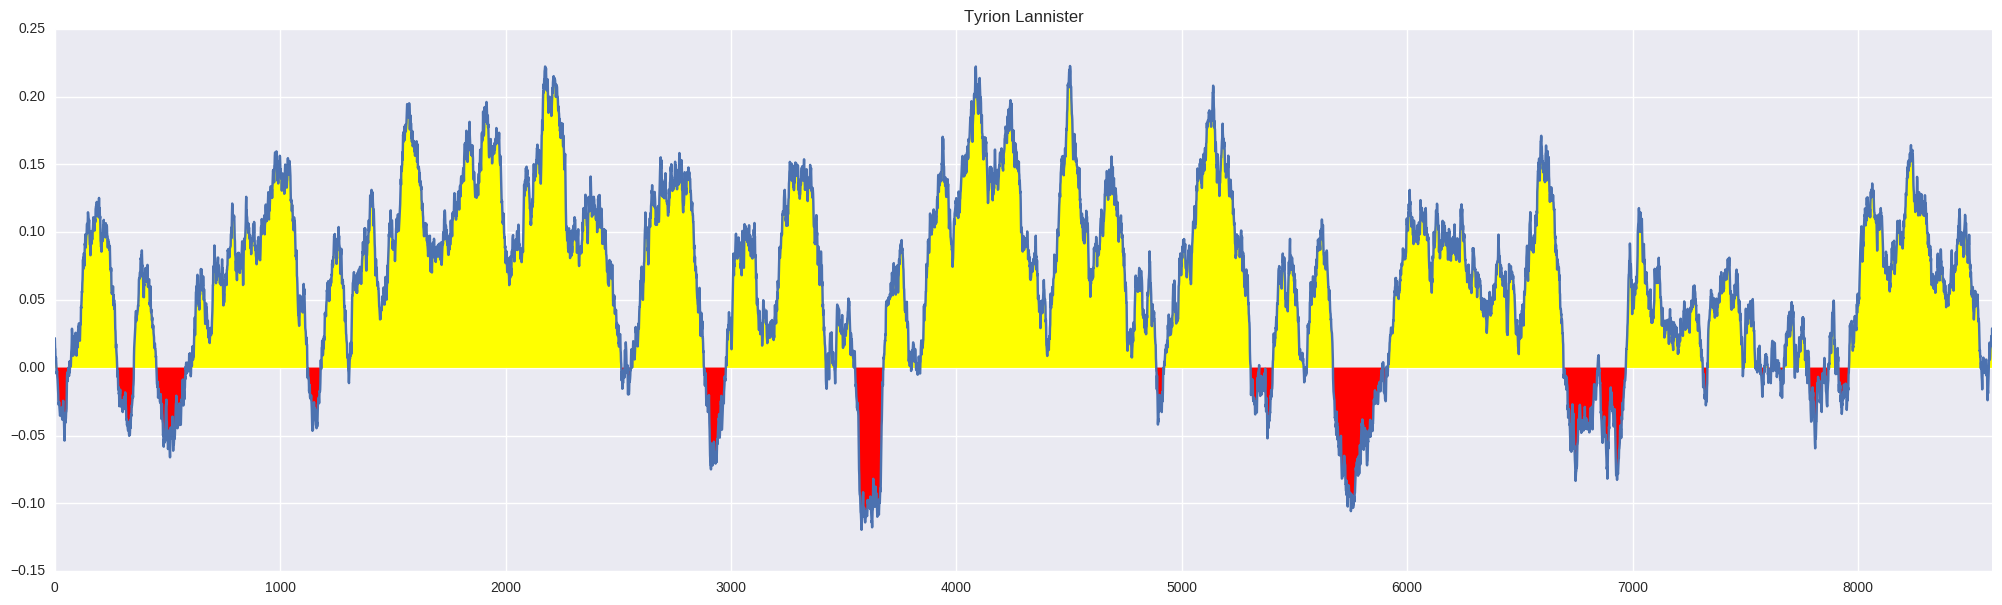

In [230]:
char_sent_plot("Tyrion Lannister", n=100, color_pos='yellow', color_neg='red')
plt.title('Tyrion Lannister');

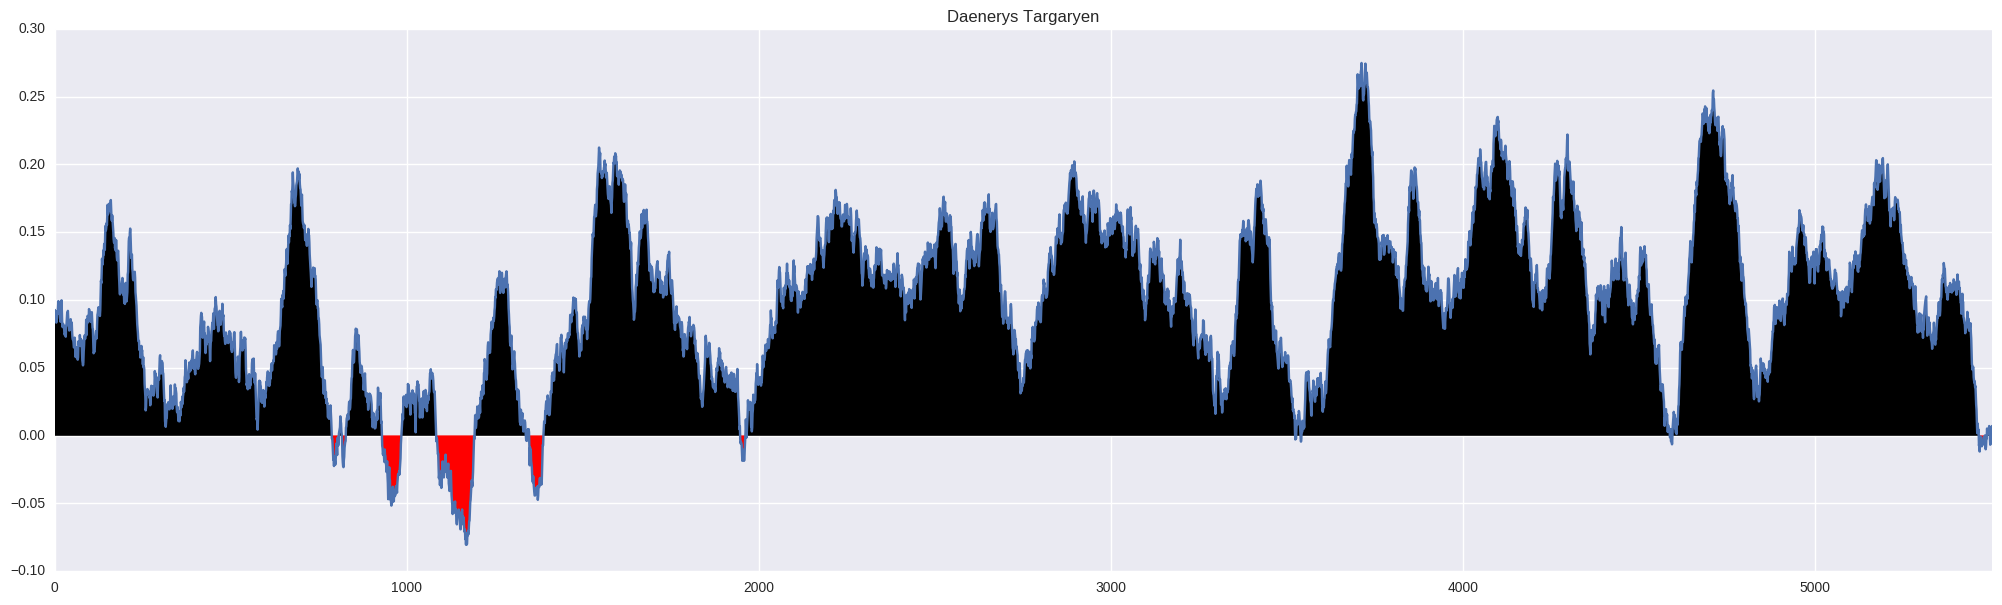

In [234]:
char_sent_plot("Daenerys Targaryen", n=100, color_pos='black', color_neg='red')
plt.title('Daenerys Targaryen');

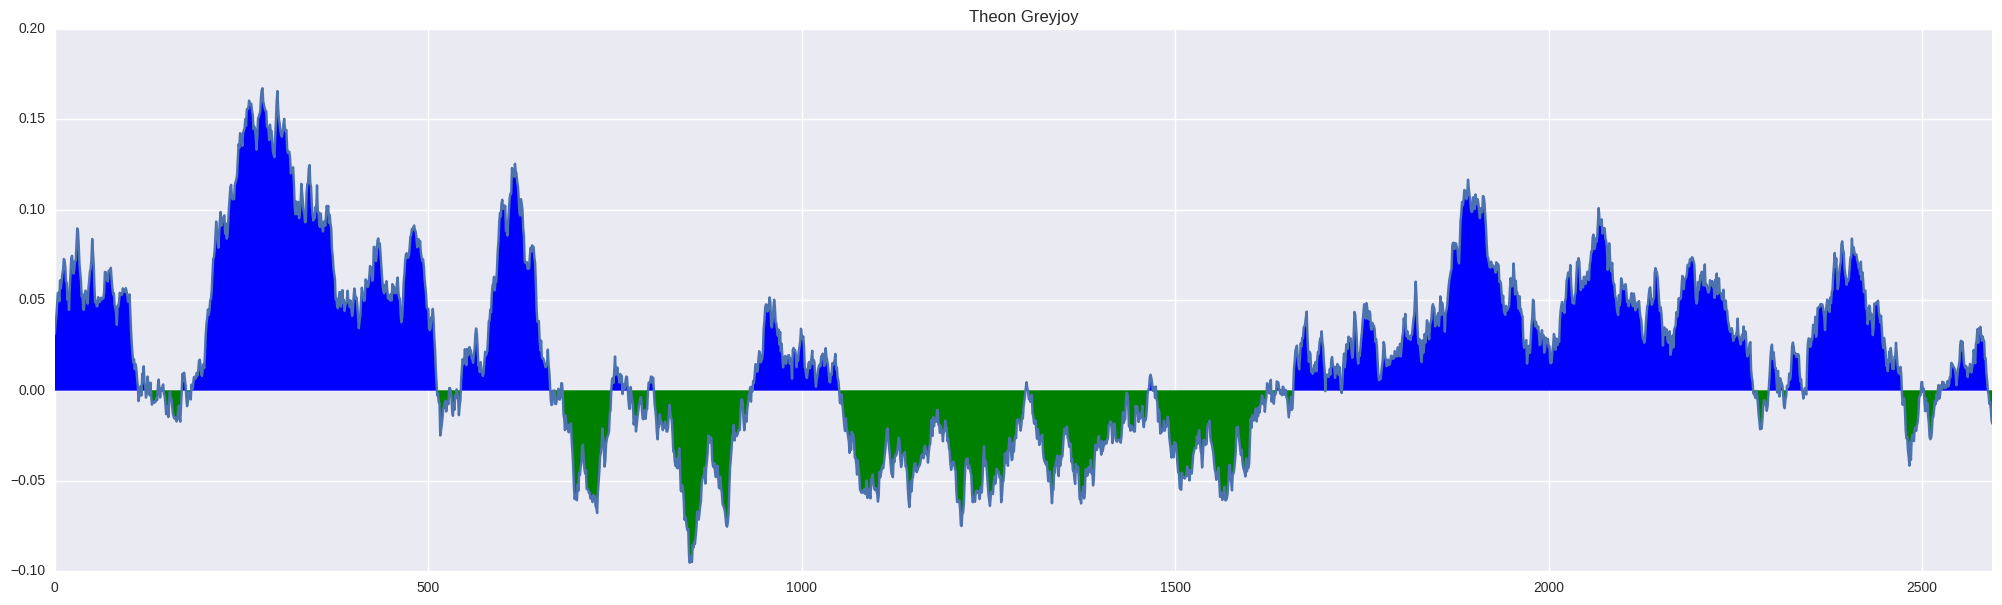

In [232]:
char_sent_plot("Theon Greyjoy", n=100, color_pos='blue', color_neg='green')
plt.title('Theon Greyjoy');

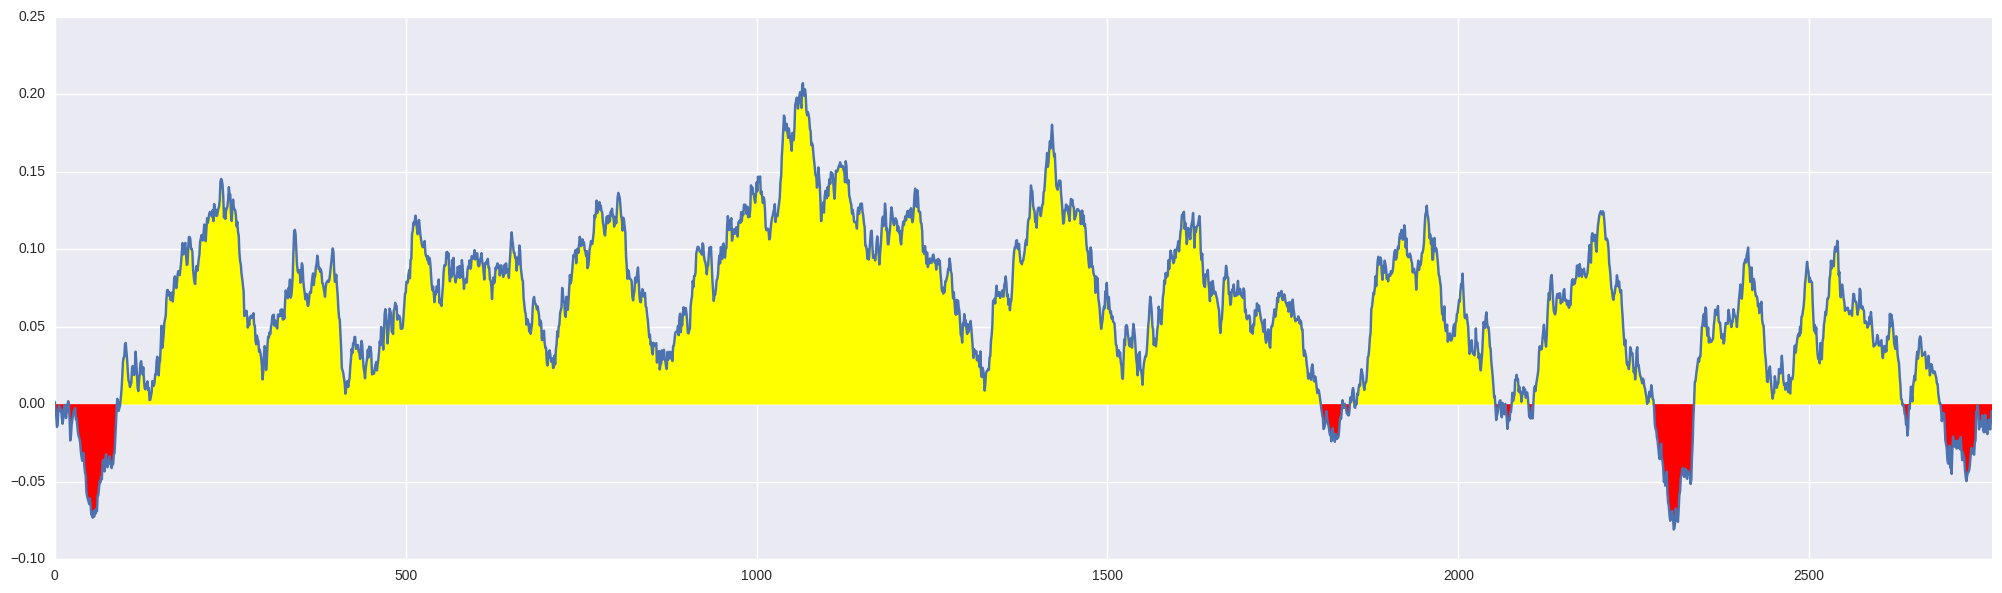

In [15]:
char_sent_plot("Cersei Lannister", n=100)

In [35]:
males = [
    'Tyrion Lannister', 
    'Jon Snow', 
    'Bran Stark', 
    'Jaime Lannister', 
    'Eddard Stark', 
    'Theon Greyjoy', 
    'Davos Seaworth',
    'Samwell Tarly',
    'Victarion Greyjoy',
    'Barristan Selmy',
    'Quentyn Martell',
    'Aeron Greyjoy',
    'Areo Hotah',
    'Jon Connington',
    'Will',
    'Chet',
    'Arys Oakheart',
    'Merrett Frey',
    'Cressen',
    'Varamyr Sixskins',
    'Kevan Lannister',
    'Pate'
    
]

females = [
    'Arya Stark', 
    'Daenerys Targaryen', 
    'Catelyn Stark', 
    'Sansa Stark',
    'Cersei Lannister',
    'Brienne of Tarth',
    'Asha Greyjoy',
    'Arianne Martell',
    'Melisandre'
]


In [309]:
dany_chaps = ice_and_fire.loc[ice_and_fire['pov'] == 'Daenerys Targaryen']
dany_docs = prep_docs(dany_chaps.sentences_stop)

bran_chaps = ice_and_fire.loc[ice_and_fire['pov'] == "Bran Stark"]
bran_docs = prep_docs(bran_chaps.sentences_stop)

arya_chaps = ice_and_fire.loc[ice_and_fire['pov'] == "Arya Stark"]
arya_docs = prep_docs(arya_chaps.pos_sentences)

cersei_chaps = ice_and_fire.loc[ice_and_fire['pov'] == "Cersei Lannister"]
cersei_docs = prep_docs(cersei_chaps.pos_sentences)

sansa_chaps = ice_and_fire.loc[ice_and_fire['pov'] == "Sansa Stark"]
sansa_docs = prep_docs(sansa_chaps.sentences_stop)

theon_chaps = ice_and_fire.loc[ice_and_fire['pov'] == "Theon Greyjoy"]
theon_docs = prep_docs(theon_chaps.sentences_stop)

tyrion_chaps = ice_and_fire.loc[ice_and_fire['pov'] == "Tyrion Lannister"]
tyrion_docs = prep_docs(tyrion_chaps.convo)

sam_chaps = ice_and_fire.loc[ice_and_fire['pov'] == "Samwell Tarly"]
sam_docs = prep_docs(sam_chaps.sentences_stop)

'''female_chaps = female_chaps = ice_and_fire.loc[ice_and_fire['pov'].isin(females)]
female_docs = prep_docs(female_chaps.sentences)

male_chaps = ice_and_fire.loc[ice_and_fire['pov'].isin(males)]
male_docs = prep_docs(male_chaps.sentences)'''

"female_chaps = female_chaps = ice_and_fire.loc[ice_and_fire['pov'].isin(females)]\nfemale_docs = prep_docs(female_chaps.sentences)\n\nmale_chaps = ice_and_fire.loc[ice_and_fire['pov'].isin(males)]\nmale_docs = prep_docs(male_chaps.sentences)"

In [256]:
topic_model(dany_docs.sentences, n_top_words=80, maxdf=0.9)

Topic #0:
dany khal drogo could dothraki back eyes blood like dragon black one red hair behind long told came men hand night face silver yet saw jorah grass horse viserys brother time irri took head high hands away beneath even first made never fire thought ser khalasar around rode feet jhiqui great place sun across skin beside looked old drogos look khaleesi bloodriders water last fingers felt still dragons see life began stone dead turned women gone must went horses air
Topic #1:
would one dany could queen well meereen dragons city men daario grace back come even day man hizdahr must great told every made upon never shall see gold three make though might take thought two little unsullied much slaves way tell go ships xaro old reznak many need girl blood daenerys qarth missandei still give astapor knew want know good hundred long us westeros may sons soon barristan gods green love people king asked children mother walls masters perhaps came
Topic #2:
said ser jorah dany man grace belw

In [314]:
topic_model(arya_docs.sentences, n_top_words=5, ntops=20, maxdf=0.45)

Topic #0:
man head hair name cloak
Topic #1:
lord beric harrenhal bolton thoros
Topic #2:
pie hot lommy harrenhal trees
Topic #3:
king gold joffrey thoros tom
Topic #4:
ser joffrey queen night harrenhal
Topic #5:
men horses others arms iron
Topic #6:
cat days braavos house night
Topic #7:
father sansa mother winterfell gods
Topic #8:
eyes feet hair woman mouth
Topic #9:
face head blood hair something
Topic #10:
hound clegane sandor beric horse
Topic #11:
gendry tom lem horses horse
Topic #12:
hand door fingers needle hands
Topic #13:
girl gods steps boy name
Topic #14:
water stone horse river side
Topic #15:
sword syrio steel blade needle
Topic #16:
one night day house god
Topic #17:
way wall day steps side
Topic #18:
yoren boy lommy wall rest
Topic #19:
time mouth fire sound swords


In [310]:
topic_model(cersei_docs.sentences, n_top_words=5, ntops=20, maxdf=0.75)

Topic #0:
cersei lady way iron castle
Topic #1:
lord gyles stannis merryweather waters
Topic #2:
ser loras osmund knight time
Topic #3:
king gods baelor blood knights
Topic #4:
grace qyburn smile water hands
Topic #5:
high septon holiness faith gold
Topic #6:
margaery tyrell cousins loras knight
Topic #7:
queen lady merryweather taena woman
Topic #8:
septa unella high holiness jaime
Topic #9:
man hair name bed years
Topic #10:
men way waters stannis boy
Topic #11:
hand jaime tyrell uncle face
Topic #12:
tommen boy mother son joffrey
Topic #13:
pycelle maester grand harys gyles
Topic #14:
robert jaime woman taena hair
Topic #15:
father tywin son girl one
Topic #16:
osney kettleblack ser osmund face
Topic #17:
eyes face woman hands tywin
Topic #18:
night day time cell wine
Topic #19:
head tyrion brother gold dwarf


In [190]:
topic_model(sansa_docs.sentences, n_top_words=80, maxdf=0.75)

Topic #0:
sansa said would could lady joffrey one like queen back father see king eyes even arya face told well know never made little want head man hand hair thought away go long make day come say look took old dont way mother prince came good knew please heard tell might looked still around went take time sweet two tyrion im much let though ever blood wine grace sister septa girl gods saw voice margaery door must think ill first black
Topic #1:
lord petyr lady said alayne robert lysa nestor would know royce us eyrie well must lords vale father boy baelish man stone young made one arryn long come little son maester old time eyes could seemed daughter though thought gave littlefinger say aunt even want never shall much back good mother wed bed moon hand child three end put castle told see tell beneath might hall way loved send night like enough take took let dont wind think small ever
Topic #2:
ser lord king one joffrey brother white knight loras red lannister knights sansa gold dontos

In [191]:
topic_model(theon_docs.sentences, n_top_words=80, maxdf=0.75)

Topic #0:
theon would could one men said old back man well black castle thought made like even never long might winterfell way see dead greyjoy snow time take come father walls still sea know eyes gods stark told hand every great go pyke away iron hed wall boy years saw keep took came enough cold uncle face night good stood feet half white turned put seen islands day behind hands wind head us asha let make stone knew found nothing last
Topic #1:
reek would ramsay said man name could back men fingers eyes see horse want long face ramsays rhymes little teeth dead know girls another remember might two even told never made head come lord way knew blood mlord dogs run skin behind make please big like prince well take still grey one gone feet bastard hands mouth must think leave day remembered hed right though let hes thought gave broken dreadfort im fear away get went hard ironborn cold good
Topic #2:
lord one ramsay bolton lady said roose would old hall us father man manderly three two dus

In [192]:
topic_model(tyrion_docs.sentences, n_top_words=80, maxdf=0.75)

Topic #0:
would one know man like little sister king well never might say think queen sweet tell could us told cersei must make go much father good see want lady take enough dwarf varys way time old friend long come prince oh still brother keep let even love joffrey girl perhaps need young yes half head true day kill better mine best may hand dragon saw find three gold rock ever lannister every back give boy landing dead tongue red grace
Topic #1:
lord tywin father king men ser hand shall varys might well lords stark stannis need see good grace lady many son great one shae never without certain lannister prince done tell leave may joffrey time castle littlefinger say new black gods bed sister please yes three must gold could city find battle man nothing want doubt made mean bring take sent think yet war believe fear hundred keep every heard enough sansa found like taken make let serve us told
Topic #2:
tyrion ser us father stark told men see come son back well boy good man give take br

In [195]:
topic_model(sam_docs.sentences, n_top_words=20, maxdf=0.5)

Topic #0:
one black snow could fire like back cold took saw grenn eyes horse made two face little another hed around
Topic #1:
gilly would could thought good even though might made man oldtown babe time jon well wind dareon never way take
Topic #2:
lord maester aemon old would man commander stannis jon king ser well must pyke years brothers know men watch us


In [318]:
for chapter in arya_chaps.pos_sentences:
    docs = []
    count = 0
    s = ''
    for sentence in chapter:
        count += 1
        s = s + sentence + ' '
        if count == 10:
            docs.append(s)
            count = 0
            s =''
    if s:
        docs.append(s)
    docs = pd.DataFrame(docs, columns=['sentences'])
    topic_model(docs.sentences, ntops=3, n_top_words=7, maxdf=.25)
    print '\n'

Topic #0:
myrcella princess jeyne lady way work beth
Topic #1:
arms swords man mouth stark master bastards
Topic #2:
nymeria wolf feet room yard mother needlework


Topic #0:
septa door mordane tom fat tower voice
Topic #1:
men time table winterfell talk day jory
Topic #2:
hand stark guard blade cloak sword eyes


Topic #0:
man stark jon lord beard cap steel
Topic #1:
cats cat claws hands door boy eyes
Topic #2:
stone steps dark torch walls way shadow


Topic #0:
meryn ser forel knight men father stick
Topic #1:
swords fear cuts man water sweat tower
Topic #2:
man left blade candle cloak head back


Topic #0:
joffrey septon high grey pulpit crowd lords
Topic #1:
gate city everyone bottom flea gods lord
Topic #2:
sword pigeon stick way bottom shops eyes


Topic #0:
men wall wagon boys landing face dungeons
Topic #1:
day donkey bull blade comet red blood
Topic #2:
winterfell city hair head nothing greenhands sept


Topic #0:
officer gold cloaks inn water eyes horses
Topic #1:
biter rorge

In [345]:
a = "myrcella princess jeyne lady way work beth arms swords man mouth stark master bastards nymeria wolf feet room yard mother needlework septa door mordane tom fat tower voice men time table winterfell talk day jory hand stark guard blade cloak sword eyes man stark jon lord beard cap steel cats cat claws hands door boy eyes stone steps dark torch walls way shadow meryn ser forel knight men father stick swords fear cuts man water sweat tower man left blade candle cloak head back joffrey septon high grey pulpit crowd lords gate city everyone bottom flea gods lord sword pigeon stick way bottom shops eyes men wall wagon boys landing face dungeons day donkey bull blade comet red blood winterfell city hair head nothing greenhands sept officer gold cloaks inn water eyes horses biter rorge wagon jaqen tankard hands arry day night back wagons beer dark babies day wagons way camp head lommy night please woman murch wagons gendry cutjack time pie hot water trees woods wagon tonight way helm holdfast face wall time ser town lake shore river water horse houses smoke wagon wood biter boy fire barn yoren dogs night lorch corpses men man guards men one hand helm boy storehouse village trees way weasel nothing time something harrenhal joffrey names chiswyck stone nan harren tywin harrenhal walls towers lannister lake callus goodwife amabel one horses sword syrio harra tower wailing day arry weasel pie hot gregor chiswyck mouse raff jaqen hand fool harrenhal face father hoat vargo winterfell riverrun man dog face hand night tower ghar lyonel sword paper men tywin walls castle pie hot thing stuff everyone ears gendry ser amory hoat vargo harrenhal lorch hot rorge biter guards bloody door glover broth girl name gods face day knife ghar ser tywin man frey roose joffrey lannisters gendry tower hot horses pie coin man winterfell robb bran rickon north moment lannisters bolton lord harrenhal roose vargo feet man time horses rain wolves ser road water man wolves rain head ground teeth back singer men look hand back sword road ale woman husband boy face friends eyes horses king door husband way table hand father beric men ser king tywin mountain hot pie time landing king boy war greenbeard anguy side riverrun run outlaws gendry thoros king master robert sword swords tongs song man sevenstrings woman anguy bridge singer smallwood child things gown man time outlaws lord town father battle robert connington bells water bars cages eyes cage iron sound girl huntsman dogs peach room lady woman shield fire arm flames blow eyes way men robert king knight scarecrow knights brother huntsman light lem mad face tom priest man fire god time outlaws dothraki cloak gendry ser hound rain face king knight septry anguy horse smoke septon head clegane time thoros fire flames riverrun priest king lady jon mother father brother wylla name song woman eyes wine tom dwarf lem sandor blackwater way joffrey back sky sound deck boat men window roundtower hands dozen water tree ferry poles lord prow hand dark silk tent wagons pink grey one pitchfork wayn farmer eyes salt pork squires castles horns man maester archers tent side riders music noise longaxes column end castles time helm knight gendry beneath face sideways hound man coat blow rock foot sack water mother river blood smells pinkeye men men crows wolves horses brothers daughter sisters time twins day night face clegane girl tickler hand wall sword head bench face wine cup ear ser neck clegane time arm squire flagon hands stone table king water yorko city houses braavos galleys harbor words nan old stories men maester luwin gods feet father god eyes doors man waif god many time eyes faced umma ser night slaves names queen ilyn meryn needle sword father sansa winterfell heart temple harbor ships sailors purple port barrow ragman merry whores lanna sailor oysters night ship wolf dreams dream arya brea house sons men way blind temple air steps morning pynto place cat inn eel sealord wine waif stick cup taste game one face one house day hands gift gods many steps iron door hand times priest sound coins shop soup time harbor purple side"
a = a.split()
a = pd.Series(a)
a.value_counts()

man             16
men             14
time            14
face            12
eyes            11
way             10
ser              9
water            9
hand             9
sword            8
day              8
king             8
father           7
night            7
horses           6
gendry           6
hot              6
head             6
winterfell       5
one              5
lord             5
back             5
harrenhal        5
tower            5
pie              5
woman            5
hands            5
door             5
boy              5
gods             4
tywin            4
knight           4
fire             4
joffrey          4
wagons           4
wagon            4
vargo            3
lady             3
city             3
swords           3
stick            3
dark             3
wine             3
biter            3
outlaws          3
riverrun         3
walls            3
tom              3
steps            3
stark            3
anguy            3
table            3
side        

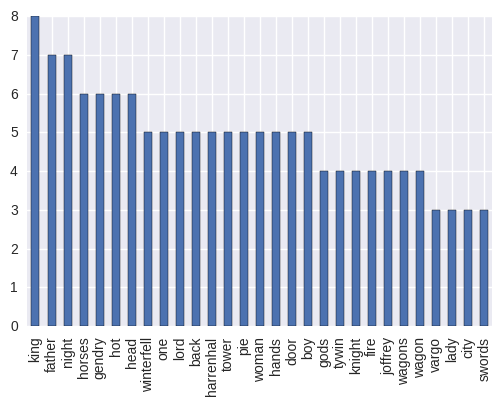

In [347]:
a.value_counts()[11:40].plot(kind='bar');

In [336]:
for chapter in cersei_chaps.sentences_stop:
    docs = []
    count = 0
    s = ''
    for sentence in chapter:
        count += 1
        s = s + sentence + ' '
        if count == 10:
            docs.append(s)
            count = 0
            s =''
    if s:
        docs.append(s)
    docs = pd.DataFrame(docs, columns=['sentences'])
    topic_model(docs.sentences, ntops=3, n_top_words=15, maxdf=.5)
    print '\n'

Topic #0:
hand would father one could jaime kings lord need tywin wanted tyrell see face know
Topic #1:
ser one cersei said queen grace boros night saw osmund lantern gone blount water woman
Topic #2:
man lord could father still must red well cersei tywin made bedchamber secret keep told


Topic #0:
lord grace garth take tyrell gyles hand would tywin highgarden serve said soon lady mother
Topic #1:
cersei would tommen ser old queen one could kevan man high like much little septon
Topic #2:
eyes tywin jaime lord gold father fathers cersei look thought king would lannister never might


Topic #0:
queen lady one king wedding said enough old still grace tyrells night wife young margaery
Topic #1:
ser margaery loras tommen tyrell half one wine jaime thought hall took back behind away
Topic #2:
said tower would hand long castle lord flames kings tyrion half rock burning even made


Topic #0:
lord pycelle stannis us maester merryweather qyburn must cersei grace gyles brothers would new may
To

In [340]:
c = "hand would father one could jaime kings lord need tywin wanted tyrell see face know ser one cersei said queen grace boros night saw osmund lantern gone blount water woman man lord could father still must red well cersei tywin made bedchamber secret keep told lord grace garth take tyrell gyles hand would tywin highgarden serve said soon lady mother cersei would tommen ser old queen one could kevan man high like much little septon eyes tywin jaime lord gold father fathers cersei look thought king would lannister never might queen lady one king wedding said enough old still grace tyrells night wife young margaery ser margaery loras tommen tyrell half one wine jaime thought hall took back behind away said tower would hand long castle lord flames kings tyrion half rock burning even made lord pycelle stannis us maester merryweather qyburn must cersei grace gyles brothers would new may would ser cersei queen grace little man waters harys qyburn well gold men osney merryweather one nose queen dwarf fools say three look head ser scars id osney please new father king rhaegar prince man told queen would girl though little ever son better jaime ser said would loras grace osmund balman know knight queen like bronn kettleblack true falyse cersei lord queen grace one would robert gyles lady could said us little long good one septon high seven sparrows could name kings gods must grace holiness fat even would would queen margaery little ser lady could well boy lord robert tommen way make litter king grace ser man us faith said holy tommen shall defend men meryn time know lord said ships stannis thousand us hands back gold well pycelle margaery qyburn iron upon said queen woman robert lady good could never grace falyse wine taena another like tell ser loras dragonstone grace redwyne queen end men castle fleet storms flowers knight galleys away would queen lord could said well man thought little hear loras tell never day even dream old tent girls eyes melara could life back three one away hands made heard grace ser one said say bring osmund tell boros head tommen boy loras much come ser must margaery would never one little queen said osney tommen cersei cousins loras told lord grace man queen gyles know would pycelle maester could need moon grand done doubt: blue cersei singer qyburn kind said grace bard us blood teeth even sweet white played septa lord us high lady holiness truth well old need pycelle cannot back margaerys say ser osney high grace must though man kettleblack osfryd away septon tyrell sweet said knight one margaery would said high septon may little trial seven know must door thought made septa said scolera unella grace might moelle good queen holiness long jaime much morning came would ser jaime one love never lord qyburn lancel queen still could come men uncle night sleep would sins queen confess tell like septa every let know last unella fornications would queen head could eyes one little never much done even lord stark day joff septa shame would high keep city scolera moelle must unella light red eyes behind see way poor fellows ser made men feet step hill keep like crowd son fell aside"

In [341]:
c = c.split()
c = pd.Series(c)
c.value_counts()

would           20
queen           18
said            16
grace           16
ser             14
lord            14
one             14
could           12
little           9
cersei           9
man              8
must             7
well             6
loras            6
jaime            6
high             6
never            6
know             6
margaery         6
lady             6
tommen           6
us               6
qyburn           5
men              5
even             5
made             5
like             5
old              4
thought          4
much             4
away             4
tell             4
eyes             4
tywin            4
septon           4
osney            4
gyles            4
king             4
father           4
back             4
septa            4
tyrell           4
pycelle          4
still            3
long             3
gold             3
keep             3
night            3
need             3
say              3
osmund           3
unella           3
told        

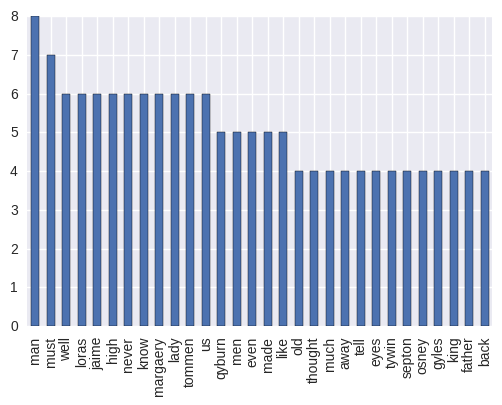

In [344]:
c.value_counts()[10:40].plot(kind='bar');

In [348]:
# combine all books to one string
all_books = ""
for x in ice_and_fire.chapter_text:
    all_books = all_books + x

# tokenize sentences
all_books = sent_tokenize(all_books)

for i, x in enumerate(all_books):
    x = re.sub(r'[^a-zA-Z ]','', x)
    x = x.lower()
    all_books[i] = x.split()

In [349]:
num_features = 100
context_size = 7
min_word_count = 3
num_workers = multiprocessing.cpu_count()


thrones2vec = gensim.models.Word2Vec(
    all_books, 
    size=num_features, 
    window=context_size, 
    min_count=min_word_count, 
    workers=num_workers,
    sg=1,
    seed=1
)

In [350]:
thrones2vec.save('thrones2vec')
saved_file = gensim.models.Word2Vec.load('thrones2vec')

In [351]:
saved_file.most_similar('king')

[('usurper', 0.7864184975624084),
 ('baratheon', 0.7365607619285583),
 ('aerys', 0.7289481163024902),
 ('traitor', 0.7285158634185791),
 ('rebellion', 0.7128637433052063),
 ('jaehaerys', 0.7112276554107666),
 ('grandson', 0.709358274936676),
 ('daerons', 0.7086013555526733),
 ('maegor', 0.7042074203491211),
 ('robert', 0.702597439289093)]